## Setup: 
Setup conda/mamba environment as specified in https://github.com/LorenFrankLab/spyglass/blob/master/environment.yml

In [2]:
import datajoint as dj

dj.config['database.host'] = "gl-ash.biostr.washington.edu" # enter datajoint host url
dj.config['database.user'] = "molly" # enter datajoint username
dj.config['database.port'] = 3306

from spyglass.utils.nwb_helper_fn import get_nwb_file
from spyglass.common.common_behav import StateScriptFile
from spyglass.common.common_task import TaskEpoch
from spyglass.common.common_nwbfile import AnalysisNwbfile
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from trials import TrialInfo
from utils.parse_trials_helper import V8TrialParser

[2024-03-14 17:19:11,119][INFO]: Connecting molly@gl-ash.biostr.washington.edu:3306
[2024-03-14 17:19:11,140][INFO]: Connected molly@gl-ash.biostr.washington.edu:3306


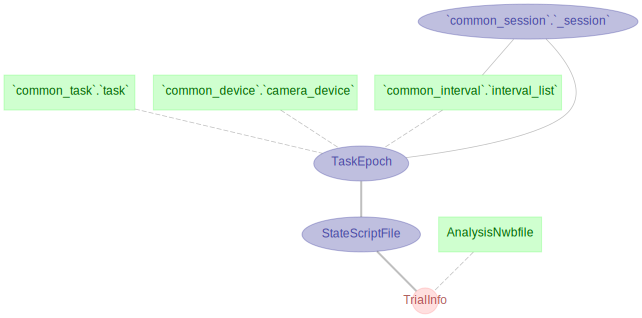

In [3]:
dj.Diagram(TaskEpoch) + dj.Diagram(TrialInfo) - 1

In [4]:
TrialInfo.heading

# 
nwb_file_name        : varchar(64)                  # name of the NWB file
epoch                : int                          # the session epoch for this task and apparatus(1 based)
---
analysis_file_name   : varchar(64)                  # name of the file
trial_info_object_id : varchar(40)                  # the NWB object ID for loading this object from the file
parser               : varchar(100)                 # type of parser used to interpret statescript log
descriptors=null     : blob                         # global descriptors for task

## Testing insert of a single session:
Normally this would be auto computed from each entry in StateScriptFile, but for now we can test inserting a single session

In [5]:
nwb_file_name = 'bobrick20231114_.nwb'

In [19]:
TrialInfo.populate(StateScriptFile & {'nwb_file_name' : nwb_file_name})

bug trial #9, epoch 4! line 267: index 0 is out of bounds for axis 0 with size 0
bug trial #10, epoch 4! line 299: 
bug trial #21, epoch 4! line 267: index 0 is out of bounds for axis 0 with size 0
bug trial #22, epoch 4! line 299: 


[14:05:35][INFO] Spyglass: Writing new NWB file bobrick20231114_OZFNY00L80.nwb


In [6]:
TrialInfo()

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),analysis_file_name name of the file,trial_info_object_id the NWB object ID for loading this object from the file,parser type of parser used to interpret statescript log,descriptors global descriptors for task
bobrick20231114_.nwb,2,bobrick20231114_LE2O27CJEA.nwb,294c1093-2c2f-44a5-bf5a-003abaff87d4,V8_delay,=BLOB=
bobrick20231114_.nwb,4,bobrick20231114_ODPCRGFSVG.nwb,d3afbb39-977d-4eb0-ba94-73349593283e,V8_delay,=BLOB=


In [7]:
# The resulting entry in AnalysisNwbfile that was generated
(AnalysisNwbfile & {"nwb_file_name" : "bobrick20231114_.nwb"})

analysis_file_name name of the file,nwb_file_name name of the NWB file,analysis_file_abs_path the full path to the file,analysis_file_description an optional description of this analysis,analysis_parameters additional relevant parameters. Currently used only for analyses
bobrick20231114_LE2O27CJEA.nwb,bobrick20231114_.nwb,=BLOB=,,=BLOB=
bobrick20231114_ODPCRGFSVG.nwb,bobrick20231114_.nwb,=BLOB=,,=BLOB=


## Reading the resulting analysis file

In [9]:
# select a specific epoch for the inserted session
key = {"nwb_file_name": nwb_file_name, "epoch": 4}

In [11]:
# retrieve a dataframe containing info from each trial on the selected epoch
filename = (TrialInfo & key).fetch1("analysis_file_name")
obj_id = (TrialInfo & key).fetch1("trial_info_object_id")
filepath = (AnalysisNwbfile & {"analysis_file_name" : filename}).fetch1("analysis_file_abs_path")
nwbfile = get_nwb_file(filepath)
trials_df = nwbfile.objects[obj_id]
trials_df

,start_time,end_time,lockout_starts,lockout_ends,during_lockout,lockout_type,rw_start,rw_end,leave_home,leave_rw,trial_type,outer_well,outer_time,leave_outer,outer_success,goal_well,rw_success
id,,,,,,,,,,,,,,,,,
1,1.699993e+09,1.699993e+09,[],[],[],0.0,1.699993e+09,1.699993e+09,1.699993e+09,1.699993e+09,2.0,5,1.699993e+09,1.699993e+09,0.0,9.0,1.0
2,1.699993e+09,1.699993e+09,[],[],[],0.0,1.699993e+09,1.699993e+09,1.699993e+09,1.699993e+09,1.0,8,1.699993e+09,1.699993e+09,0.0,9.0,1.0
3,1.699993e+09,1.699993e+09,[],[],[],0.0,1.699993e+09,1.699993e+09,1.699993e+09,1.699993e+09,2.0,6,1.699993e+09,1.699993e+09,0.0,9.0,1.0
4,1.699993e+09,1.699993e+09,[1699993381.5339506],[1699993411.5339506],[10],1.0,1.699993e+09,1.699993e+09,1.699993e+09,1.699993e+09,2.0,0,0.000000e+00,0.000000e+00,0.0,9.0,1.0


In [13]:
# option: run this cell to get an interactive plot (only works in jupyter, not vscode)
%matplotlib notebook

Using matplotlib backend: <object object at 0x7faab38e17d0>


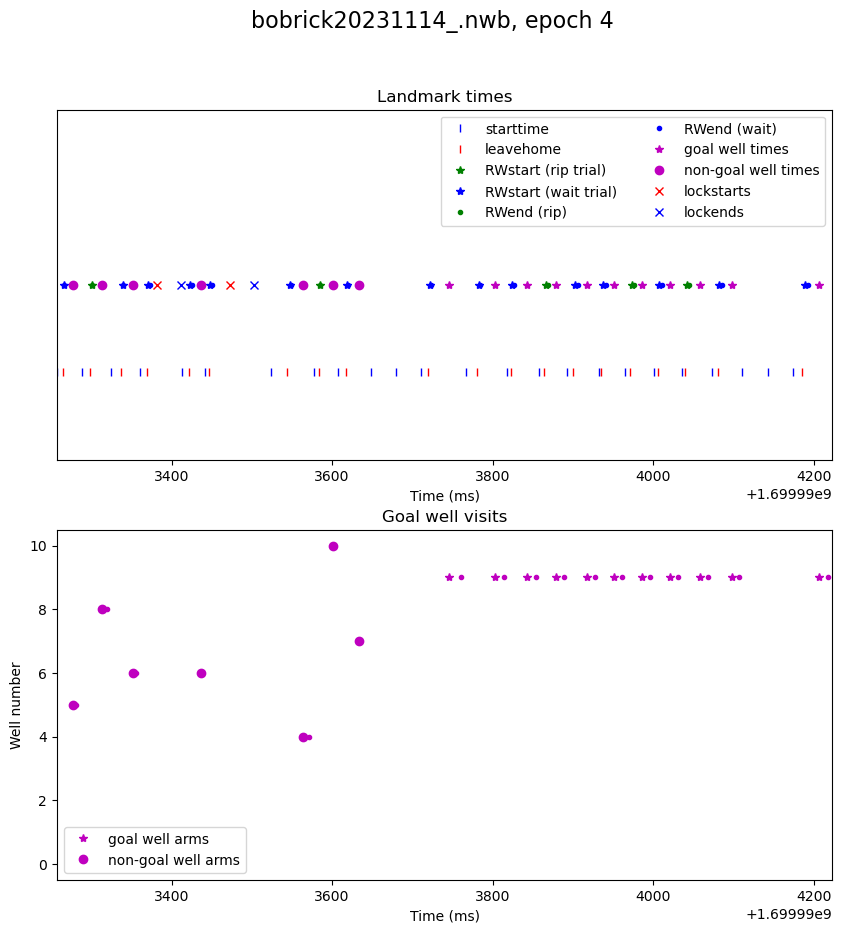

In [12]:
# optional: visualize landmark times during epoch
V8TrialParser.plot_trials(trials_df, key)

## Deleting Entries
* Delete analysis file from the AnalysisNwbfile table, which automatically removes the corresponding entry in the TrialsInfo table
* Remove the unused analysis files from storage

In [6]:
# AnalysisNwbfile is upstream, so this should automatically delete the entry in TrialsInfo that generated it?
(AnalysisNwbfile & {"nwb_file_name" : "bobrick20231114_.nwb"}).delete()

[14:52:46][INFO] Spyglass: Building merge cache for analysis_nwbfile.
	Found 2 downstream merge tables
[2024-03-14 14:52:46,802][INFO]: Deleting 2 rows from `TrialsInfo`.`__trials_info`
[2024-03-14 14:52:46,814][INFO]: Deleting 2 rows from `common_nwbfile`.`analysis_nwbfile`
[2024-03-14 14:52:49,797][INFO]: Deletes committed.


In [7]:
# ah, this proves the above is correct
TrialInfo & {"nwb_file_name" : "bobrick20231114_.nwb"}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),analysis_file_name name of the file,trial_info_object_id file object id pointing to trial analysis,parser type of parser used to interpret statescript log,descriptors global descriptors for task


In [8]:
# i think this deletes the files from the computer but not the actual AnalysisNwbfile table.
# an extra merge cache file is generated, but this seems to disappear after a few hours
AnalysisNwbfile.cleanup(delete_files=True)

100%|██████████| 2/2 [00:00<00:00, 15.78it/s]
